# Overview
In this workbook, we'll leverage Sklearn's TFIDF vectorizer and MiniBatchKmeans to perform some simple document clustering. After which , we'll plot the clusters using PCA and TSNE, then show the top keywords in each cluster.

In [1]:
import os
import re
import csv
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from nltk.tokenize import sent_tokenize
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Importing the data
Importing the data is simple with Pandas. The source file is a newline delimited JSON file

In [2]:
data = pd.read_csv('crawling_berita/Detik/detik_covid.csv', encoding = "ISO-8859-1")

newsTotal=[]
for news in data.content.values:
    newsTotal.append(news)

newsTotal

[' Surabaya - Kasus COVID- aktif di Jawa Timur terus bertambah. Saat ini, total ada . kasus COVID- aktif.Mengantisipasi hal tersebut, Pemprov Jatim akan menambah lagi Rumah Sakit Lapangan COVID- . Guna memfasilitasi masyarakat yang terdeteksi COVID- , Pemprov Jatim menambah lagi RS Lapangan COVID- di Jember.Sebelumnya Pemprov Jatim menambah Rumah Sakit Lapangan di Malang. Tepatnya di Politeknik Kesehatan Malang (Polkesma) Kota Malang. "Untuk RS Lapangan di Malang untuk memfasilitasi pasien COVID- di Malang Raya dan Blitar. RS Lapangan yang ada di Jalan Ijen Kota Malang itu berkapasitas tempat tidur," ujar Sekdaprov Jatim, Heru Tjahjono di Surabaya, Senin ( / / ). Selanjutnya Halaman kasus covid- rs lapangan jember pemprov jatim birojatim ',
 ' Jakarta - Saham Disney (DIS) melonjak % pada Jumat lalu ke level tertinggi baru sepanjang masa. Sekarang sahamnya naik lebih dari % di tahun ini. Itu menjadi suatu prestasi yang mengesankan, mengingat pandemi COVID- telah mendatangkan malapetaka 

## Preprocess Data

In [3]:
def casefolding(sentence):
    return sentence.lower()

def cleaning(sentence):
    return re.sub( '\s{2,}',' ',re.sub(r'[^a-z]',' ', re.sub("’", ' ', sentence)))


def tokenization(sentence):
    return sent_tokenize(sentence)

def stopword_removal(token):
    temp = []
    for i in range(len(token)):
        if token[i] not in stopwords:
            temp.append(token[i])
    return temp

def sentence_split(paragraph):
    return nltk.sent_tokenize(paragraph)


sentence_list = sentence_split(newsTotal[0])
data = []
for sentence in sentence_list:
    data.append(cleaning(casefolding(sentence)))

data

[' surabaya kasus covid aktif di jawa timur terus bertambah ',
 'saat ini total ada ',
 'kasus covid aktif mengantisipasi hal tersebut pemprov jatim akan menambah lagi rumah sakit lapangan covid ',
 'guna memfasilitasi masyarakat yang terdeteksi covid pemprov jatim menambah lagi rs lapangan covid di jember sebelumnya pemprov jatim menambah rumah sakit lapangan di malang ',
 'tepatnya di politeknik kesehatan malang polkesma kota malang ',
 ' untuk rs lapangan di malang untuk memfasilitasi pasien covid di malang raya dan blitar ',
 'rs lapangan yang ada di jalan ijen kota malang itu berkapasitas tempat tidur ujar sekdaprov jatim heru tjahjono di surabaya senin ',
 'selanjutnya halaman kasus covid rs lapangan jember pemprov jatim birojatim']

## Extracting keywords
Here I use the TfidfVectorizer since I'm hoping the IDF score will pull out unique words that I can use in clustering. There are lots of options to explore here to get different results, including CountVectorizer

In [147]:
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english'
)
tfidf.fit(data.content)
text = tfidf.transform(newsTotal)

AttributeError: 'list' object has no attribute 'content'

## Finding Optimal Clusters
Clustering is an unsupervised operation, and KMeans requires that we specify the number of clusters. One simple approach is to plot the SSE for a range of cluster sizes. We look for the "elbow" where the SSE begins to level off. MiniBatchKMeans introduces some noise so I raised the batch and init sizes higher. Unfortunately the regular Kmeans implementation is too slow. You'll notice different random states will generate different charts. Here I chose 14 clusters.

In [89]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 20)

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters


ValueError: n_samples=17 should be >= n_clusters=18

In [76]:
clusters = MiniBatchKMeans(n_clusters=14, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

## Plotting Clusters
Here we plot the clusters generated by our KMeans operation. One plot uses PCA which is better at capturing global structure of the data. The other uses TSNE which is better at capturing relations between neighbors. In order to speed up the process with TSNE, I sample from 3,000 documents and perform a PCA 50 dimension reduction on the data first. Next I show a scatterplot further sampling the sample down to 300 points.

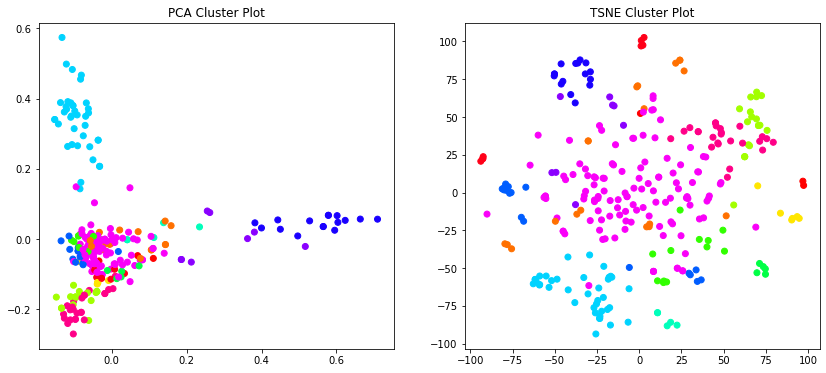

In [77]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(text, clusters)
    

## Top Keywords
Lastly, we'll cycle through the clusters and print out the top keywords based on their TFIDF score to see if we can spot any trends. I'll do this by computing an average value across all dimensions in Pandas, grouped by the cluster label. Using numpy, finding the top words is simply sorting the average values for each row, and taking the top N.

You can see that we have a pretty good result. Topics including exploitation of children, tax fraud, civil rights, and environmental issues can be inferred from the top keywords. Other interesting approaches to this might include LDA topic modeling or possibly working with pre-trained word embeddings.

In [27]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, tfidf.get_feature_names(), 20)


Cluster 0
lockdown,meninggal,negeri,sun,bdh,pegawai,ditutup,birojatim,terpapar,positif,pegawainya,pn,kantor,agama,klaster,covid,hakim,perkantoran,pengadilan,banyuwangi

Cluster 1
ini,forbes,bansos,dan,bambang,pesta,virus,daftar,dari,indonesia,google,di,covid,yang,orang,rp,alat,tes,terkaya,corona

Cluster 2
bogor,yang,melakukan,tegas,polisi,jakarta,kapolda,di,swab,tersangka,petamburan,kerumunan,shihab,fpi,ormas,polda,jaya,metro,habib,rizieq

Cluster 3
cepat,pilbup,hitung,menang,tangsel,yang,persen,calon,dan,hasil,suara,kemenangan,kpu,serentak,di,quick,paslon,pasangan,count,pilkada

Cluster 4
tahun,dana,juta,keuangan,penerima,indonesia,triliun,blt,untuk,anggaran,bansos,ekonomi,rp,umkm,yang,investasi,dan,bantuan,bank,program

Cluster 5
pulih,lagi,doa,pribadinya,instagram,puji,akun,dan,fadhil,ia,syariah,segala,covid,corona,allah,saham,positif,ustaz,yusuf,mansur

Cluster 6
tanda,infeksi,seseorang,kebingungan,dialami,kondisi,bisa,menemukan,peneliti,persen,mata,yang,virus,tenggorokan,sakit,c